<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/03_Tutorial_ResNet_VAE_Tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD

* Post-InfoSec-Exp
* Continue:
    * 01.Tutorial-ResNet-VAE -Epoch5
    * Reduce Learning Rate

* Fix Error:
    * CUDA OOM(Out of Memory) Error Handling
    * reduce hidden layer size 1024 to 512
    * reduce CNN_embed_dim 256 to 100


* mount drive

In [1]:
# drive mount

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd drive/My\ Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
! ls

/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master
'01.Tutorial-ResNet-VAE.ipynb의 사본'	        __pycache__
 01.Tutorial-ResNet-VAE-Recon.ipynb	        README.md
 02.Tutorial-ResNet-VAE-Tunning.ipynb	        recon_sampling
 03.Tutorial-ResNet-VAE-Tunning.ipynb	        reconstruction_Malimg.png
'03.Tutorial-ResNet-VAE-Tunning.ipynb의 사본'   ResNetVAE_cifar10.py
 fig					        ResNetVAE_FACE.py
 generated_Malimg.png			        ResNetVAE_MNIST.py
 modules.py				        ResNetVAE_reconstruction.ipynb
 plot_latent.ipynb			        results_Malimg
 plot_latent_vector			        results_Malimg_Exp2
 plot_train_test_loss			        results_Malimg_Exp3


In [4]:
import os

path = os.getcwd()
path

'/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master'

In [5]:
path = path + '/results_Malimg_Exp3'
path

'/content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/results_Malimg_Exp3'

In [6]:

# make directory
# 실험을 한 번 끝낸 이후로는 사용 x


def makedir(dirname):
    
    try:
        os.mkdir(path + '/' + dirname)
        print("Successfully created the directory in %s" % path)
    except OSError:
        print('Failed !!')
        print("Creation of the directory %s failed" % path)
    else:
        # print("Successfully created the directory %s" % path)
        pass
    return

dir_list = ['recon_sampling', 'plot_train_test_loss', 'plot_latent_vector']

In [7]:
for i in range(len(dir_list)):
    # print(dir_list[i])
    # print(path + '/' + dir_list[i])
    makedir(dir_list[i])
! ls

Failed !!
Creation of the directory /content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/results_Malimg_Exp3 failed
Failed !!
Creation of the directory /content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/results_Malimg_Exp3 failed
Failed !!
Creation of the directory /content/drive/My Drive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/results_Malimg_Exp3 failed
'01.Tutorial-ResNet-VAE.ipynb의 사본'	        __pycache__
 01.Tutorial-ResNet-VAE-Recon.ipynb	        README.md
 02.Tutorial-ResNet-VAE-Tunning.ipynb	        recon_sampling
 03.Tutorial-ResNet-VAE-Tunning.ipynb	        reconstruction_Malimg.png
'03.Tutorial-ResNet-VAE-Tunning.ipynb의 사본'   ResNetVAE_cifar10.py
 fig					        ResNetVAE_FACE.py
 generated_Malimg.png			        ResNetVAE_MNIST.py
 modules.py				        ResNetVAE_reconstruction.ipynb
 plot_latent.ipynb			        re

## 01. Import Library

In [8]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

# load modules
from torchvision import models
from modules import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preparation
* Make Custom Dataset
* Make Custom DataLoader
* Train_Test Split

### Work Flow
* transforms module 사용, Image data compose(전처리, transform)
* re-sizing, normalizing, tensor
* ImageFolder사용 dataloader
* dataset split: train dataset, test dataset
* DataLoader: batch단위 dataset loading

In [9]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=3),  # Makes it 3-dimension channel
                                                                              # Simple way
                                                                              # https://pytorch.org/docs/stable/torchvision/transforms.html
                                                                              # If num_output_channels == 3 : returned image is 3 channel with r == g == b
                                 
                                # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                                                                 # Reference: https://github.com/hsinyilin19/ResNetVAE/blob/master/ResNetVAE_MNIST.py
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]), 
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../../../../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [10]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [11]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


batch_size: 4 to 16

In [12]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
valid_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

### 3-Channel Image를 출력해보자
* -20.07.30.Thur-

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([24, 24,  2,  7,  2, 11, 17, 24, 24,  3,  3,  3, 10,  2,  2,  8])


torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
Yuner.A Yuner.A Allaple.A C2LOP.gen!g 


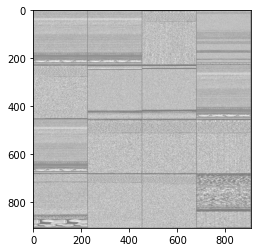

In [15]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(4)))

## 03. Modeling
* save model: <code>save_model_path</code>
* save_loss_list
* etc...


* Hyper Parameters
    * CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
    * CNN_embed_dim = 256  # latent dim extracted by 2D CNN
    * res_size = 224  # ResNet image size
    * dropout_p = 0.2  # dropout probability
    * Epochs = 50
    * batch_size = 16
    * learning_rate = 1e-5
    * log_interval = 10  # The time between data samples being taken

In [25]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024  # change it to 256
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
                        # change it to 100
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

# training parameters
epochs = 50        # training epochs
# batch_size = 4
learning_rate = 1e-5
log_interval = 10   # interval for displaying training info

In [17]:
# save model
save_model_path = './results_Malimg_Exp3'  # save_model parameter

In [18]:
def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

### Define Loss Function

In [19]:
def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # mse, kld의 값도 확인하고 싶은데... 어떻게 하면 좋을까??
    # Loss Function 호출시마다 값을 저장해준다
    mse_loss.append(MSE)   # save MSE & Kullback Liebler
    kld_loss.append(KLD)

    return MSE + KLD

### Define Training Process
* train, validation
* train:
    * save model's state_dict
    * save optim's state_dict
* test:
    * save Recon Image
    * 

In [20]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        # calc loss
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())
        # backward()
        loss.backward()
        # optimize
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch +1 + 3, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch+ 1 + 3)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch+ 1 + 3)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1 + 3))  # 5 Epoch부터 이어서 Training하기 때문

    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()  # set testing mode: model.eva()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():  # gradient 추적을 하지 않는다고 우선 선언
        for i, (X, y) in enumerate(test_loader):
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)
            # calc loss
            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss
            
            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

            ##########################################
            ########   Debugging            ##########
            ##########################################
            # print('='*20)
            # print('Debugging')
            # print('X_recon_Shape:', X_reconst.shape)

        ## Save_Recon_Malimg
            if i == 0:
                n = min(X.size(0), 8)
                comparison = torch.cat([X[:n],
                                    X_reconst.view(16, 3, 224, 224)[:n]])  # Recon 4 Images
                save_image(comparison.cpu(),
                        './results_Malimg_Exp3/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss


In [21]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

### Load_State_Dict

<code>Exp03.에서는 지난 실험의 Model Parameter를 불러오지 않는다.</code>
-20.07.30.thur-

* 이전 학습에서 저장했던 model parameter를 불러온다<br>


<code>pre_saved_model_path</code>: 지난번 1e-3에서 5Epoch학습한 모델의 파라미터

In [26]:
pre_saved_model_path = './results_Malimg_Exp3'
epoch = 3

# reload ResNetVAE model
####    reload -> x    ####
####    Train Again    ####


# Define Model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

# pre-trained-model을 불러오지 않는다

resnet_vae.load_state_dict(torch.load(os.path.join(pre_saved_model_path, 'model_epoch{}.pth'.format(epoch))))
print("ResNet VAE epoch {} model reloaded!".format(epoch))


ResNet VAE epoch 3 model reloaded!


In [28]:
# resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
# print('models params:', model_params)
optimizer = torch.optim.Adam(model_params, lr=learning_rate)  # After5 lr 1e-3 to 1e-5

Using 1 GPU!


In [29]:

# record training process
'''
list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []
'''
list_epoch=[]
epoch_train_losses = []
epoch_test_losses = []
mse_loss = []
kld_loss = []
list_acc = []
list_acc_epoch =[]
check_mkdir(save_model_path)

## 04. Train-it

In [31]:
# start training
for epoch in range(epochs):

    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    list_epoch.append(epoch)
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    
    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'X_Malimg_train_epoch{}.npy'.format(epoch + 1 + 3)), X_train) #save last batch
    np.save(os.path.join(save_model_path, 'y_Malimg_train_epoch{}.npy'.format(epoch + 1 + 3)), y_train)
    np.save(os.path.join(save_model_path, 'z_Malimg_train_epoch{}.npy'.format(epoch + 1 + 3)), z_train)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train Epoch: 4 [160/7471 (2%)]	Loss: 1651272.875000
Train Epoch: 4 [320/7471 (4%)]	Loss: 1652609.500000
Train Epoch: 4 [480/7471 (6%)]	Loss: 1644344.500000
Train Epoch: 4 [640/7471 (9%)]	Loss: 1647880.125000
Train Epoch: 4 [800/7471 (11%)]	Loss: 1644015.375000
Train Epoch: 4 [960/7471 (13%)]	Loss: 1665922.875000
Train Epoch: 4 [1120/7471 (15%)]	Loss: 1660394.875000
Train Epoch: 4 [1280/7471 (17%)]	Loss: 1641039.125000
Train Epoch: 4 [1440/7471 (19%)]	Loss: 1650073.625000
Train Epoch: 4 [1600/7471 (21%)]	Loss: 1619946.875000
Train Epoch: 4 [1760/7471 (24%)]	Loss: 1645577.125000
Train Epoch: 4 [1920/7471 (26%)]	Loss: 1632606.625000
Train Epoch: 4 [2080/7471 (28%)]	Loss: 1643696.500000
Train Epoch: 4 [2240/7471 (30%)]	Loss: 1647655.125000
Train Epoch: 4 [2400/7471 (32%)]	Loss: 1657590.875000
Train Epoch: 4 [2560/7471 (34%)]	Loss: 1638639.375000
Train Epoch: 4 [2720/7471 (36%)]	Loss: 1645206.500000
Train Epoch: 4 [2880/7471 (39%)]	Loss: 1622098.375000
Train Epoch: 4 [3040/7471 (41%)]	Loss:

RuntimeError: ignored

In [29]:
import torch
torch.cuda.empty_cache()

In [30]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [47]:
torch.cuda.memory_summary(device=None, abbreviated=False)   # This commend provides us the summary of allocation of CUDA memory

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 8            |        cudaMalloc retries: 9         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   14170 MB |   14272 MB |   12347 GB |   12333 GB |\n|       from large pool |   13744 MB |   13843 MB |   12068 GB |   12054 GB |\n|       from small pool |     426 MB |     513 MB |     279 GB |     278 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |   14170 MB |   14272 MB |   12347 GB |   12333 GB |\n|       from large pool |   13744 MB |   13843 MB |

In [30]:
! nvidia-smi

Thu Jul 30 06:28:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |  16279MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### plot_train_val_loss plot

In [ ]:
fig = plt.figure(figsize=(15, 5))

# ======= Loss Fluctuation ======= #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, epoch_train_losses, label='train_loss')
ax1.plot(list_epoch, epoch_test_losses, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

plt.savefig('./results_Malimg_Exp3/plot_latent_vector/' + str(epoch) + '_t_SNE.png', dpi=300)


'''
# ======= Metric Fluctuation ======= # 
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()
'''